In [1]:
#Import libraries
import requests
import pandas as pd
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials


#Data visualization
import seaborn as sn
import matplotlib.pyplot as plt
import random
#Data Manipulation
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
# Machine Learning
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Input, Activation
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, KFold
from sklearn.compose import ColumnTransformer
np.random.seed(39)
random.seed(39)
tf.random.set_seed(39)
print(tf.__version__)

2024-03-07 18:43:35.799578: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-07 18:43:35.879293: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-07 18:43:35.896840: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-07 18:43:36.200728: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvi

2.10.0


In [2]:
space = {
    'num_layers': hp.choice('num_layers', [2, 3, 4, 5]),
    'units_layer': hp.choice('units_layer', [64, 128, 256, 300,400,512]),
    'batch_size': hp.choice('batch_size', [128]),
    'epochs': hp.quniform('epochs', 150, 800, 50),  # Range of epochs from 150 to 800 with steps of 50
    'learning_rate': hp.loguniform('learning_rate', -5, -2)
}

In [3]:
#GRAIN_TYPE = 'Wheat'
GRAIN_TYPE = 'Combined_Grains'
FILENAME_BEST_MODEL = 'Best models/target_2/hybrid_models/' + GRAIN_TYPE + 'classifyVariety.h5'
URL = "../../Datasets/processed/" + GRAIN_TYPE + ".csv"
df = pd.read_csv(URL)
# Convert to numpy array
#df = df.groupby('Variety').head(120)
df_features = df[[ 
                    'Freq', 
                    'd(cm)', 
             #       'Attn', 
                    'Phase_Corr', 
                    'Permittivity_real', 
                    'Permittivity_imaginary',
                    ]]

df_targets = df[['Grain Type']]
# df_targets = df[['Density', 'M%']]

dataset_x = df_features.to_numpy()
scaler = StandardScaler()
dataset_x = scaler.fit_transform(dataset_x)
dataset_y = df_targets.to_numpy()

In [4]:
from sklearn.preprocessing import LabelEncoder

# Getting the number of unique varieties
num_varieties = df_targets['Grain Type'].nunique()
varieties = df_targets['Grain Type'].unique()
print(f'There are {num_varieties} different varieties.')

# Encode the 'variety' labels
label_encoder = LabelEncoder()
# Step 1: Convert varieties into number ex. 1 2 3... and store in a single list
integer_encoded = label_encoder.fit_transform(df_targets['Grain Type'])
# Step 2: Get the number of different classes
depth = num_varieties
# Step 3: Pass in the list of numerical values and the number of classes and vectors are created 
#         For example the value 4 would be passed and converted to [0. 0. 0. 0. 1.]
one_hot_encoded = tf.one_hot(integer_encoded, depth)
# Step 4: Convert to numpy arr
y_one_hot = one_hot_encoded.numpy()  # If using TensorFlow's one_hot


There are 5 different varieties.


2024-03-07 18:43:36.686603: E tensorflow/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: CUDA_ERROR_COMPAT_NOT_SUPPORTED_ON_DEVICE: forward compatibility was attempted on non supported HW
2024-03-07 18:43:36.686627: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: usda-ars
2024-03-07 18:43:36.686633: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: usda-ars
2024-03-07 18:43:36.686721: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 535.161.7
2024-03-07 18:43:36.686740: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 535.154.5
2024-03-07 18:43:36.686744: E tensorflow/stream_executor/cuda/cuda_diagnostics.cc:313] kernel version 535.154.5 does not match DSO version 535.161.7 -- cannot find working devices in this configuration
2024-03-07 18:43:36.687156: I tensorflow/core/platform/cpu_feature_guard.cc:193] This Tensor

In [5]:
'''
Uncomment this to have the dataset split be uniform in test set but not train set, no val included.
'''

# from sklearn.model_selection import train_test_split
# import tensorflow as tf

# # Assume other parts of the code (dataset_x, y_integers, depth) are defined as in previous examples

# # Perform stratified train-test split on the data to maintain class distribution
# X_train, X_temp, y_train_integer, y_temp_integer = train_test_split(
#     dataset_x, integer_encoded, test_size=0.20, stratify=integer_encoded, random_state=42
# )
# # Convert the integer labels back to one-hot encoding for TensorFlow/Keras for the training set
# y_train = tf.one_hot(y_train_integer, depth).numpy()

# # Now create a balanced test set from X_temp and y_temp_integer
# unique_classes = np.unique(y_train_integer)
# samples_per_class = min(np.bincount(y_temp_integer))  # Find the smallest class size in the test set

# # Create a list to store the sampled indices
# indices_to_keep = []

# for cls in unique_classes:
#     # Get the indices for each class
#     class_indices = np.where(y_temp_integer == cls)[0]
#     # Randomly choose 'samples_per_class' indices from each class
#     chosen_indices = np.random.choice(class_indices, size=samples_per_class, replace=False)
#     indices_to_keep.extend(chosen_indices)

# # Use the indices to create the balanced test set
# X_test = X_temp[indices_to_keep]
# y_test_integer = y_temp_integer[indices_to_keep]

# # Convert the integer labels back to one-hot encoding for TensorFlow/Keras for the test set
# y_test = tf.one_hot(y_test_integer, depth).numpy()


'\nUncomment this to have the dataset split be uniform in test set but not train set, no val included.\n'

In [8]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf

# Assuming dataset_x and dataset_y are already defined
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(dataset_y.ravel())  # Assuming dataset_y is 1D
depth = len(np.unique(integer_encoded))  # Number of classes

# Calculate the fraction for the test size based on the smallest class size
_, counts = np.unique(integer_encoded, return_counts=True)
min_class_size = min(counts)
test_fraction = min_class_size / sum(counts)  # Fraction of the dataset to use as the test set for balance

# Split the dataset into training+validation and test sets in a stratified manner
X_train_val, X_test, y_train_val, y_test = train_test_split(
    dataset_x, integer_encoded, test_size=test_fraction, stratify=integer_encoded, random_state=42
)

# Further split the training+validation set into actual training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.25, stratify=y_train_val, random_state=42
)

# Convert integer labels to one-hot encoding for TensorFlow/Keras
y_train_one_hot = tf.one_hot(y_train, depth).numpy()
y_val_one_hot = tf.one_hot(y_val, depth).numpy()
y_test_one_hot = tf.one_hot(y_test, depth).numpy()

# Function to print the class distribution for the splits
def print_class_distribution(y, label, encoder):
    _, class_counts = np.unique(y, return_counts=True)
    class_names = encoder.inverse_transform(np.unique(y))
    distribution = dict(zip(class_names, class_counts))
    print(f'{label} Class Distribution:')
    for class_name, count in distribution.items():
        print(f'  {class_name}: {count}')

print_class_distribution(y_train, 'Training', label_encoder)
print_class_distribution(y_val, 'Validation', label_encoder)
print_class_distribution(y_test, 'Test', label_encoder)


Training Class Distribution:
  Barley: 245
  Corn: 886
  Oats: 324
  Sorghum: 267
  Wheat: 539
Validation Class Distribution:
  Barley: 81
  Corn: 296
  Oats: 108
  Sorghum: 89
  Wheat: 180
Test Class Distribution:
  Barley: 40
  Corn: 143
  Oats: 53
  Sorghum: 43
  Wheat: 87


In [ ]:
def print_dataset_split(y_train_integer,y_test_integer):
    # Create a DataFrame for the training set class distribution
    train_counts = pd.DataFrame({
        'Class Name': label_encoder.inverse_transform(np.unique(y_train_integer)),
        'Train': np.bincount(y_train_integer)
    })

    # Create a DataFrame for the balanced test set class distribution
    test_counts = pd.DataFrame({
        'Class Name': label_encoder.inverse_transform(np.unique(y_test_integer)),
        'Test': np.bincount(y_test_integer)
    })

    # Merge the two DataFrames on Class Name
    combined_counts = pd.merge(train_counts, test_counts, on='Class Name', how='outer').fillna(0)

    # Converts to integer type
    combined_counts['Train'] = combined_counts['Train'].astype(int)
    combined_counts['Test'] = combined_counts['Test'].astype(int)

    # Set display options for pandas
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', 1000)
    pd.set_option('display.colheader_justify', 'center')
    pd.set_option('display.precision', 3)

    # Print combined class counts in a tabular format
    print(combined_counts.to_string(index=False, justify='right'))


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import numpy as np
from hyperopt import space_eval

metrics = ['accuracy']  # General accuracy for all classes

# Add precision and recall for each class
for i in range(depth):
    metrics.append(tf.keras.metrics.Precision(class_id=i, name=f'precision_class_{i}'))
    metrics.append(tf.keras.metrics.Recall(class_id=i, name=f'recall_class_{i}'))

def objective(params):
    model = Sequential()
    model.add(Dense(int(params['units_layer']), activation='relu'))
    for _ in range(int(params['num_layers']) - 1):
        model.add(Dense(int(params['units_layer']), activation='relu'))
    model.add(Dense(5, activation='softmax'))

    model.compile(optimizer=Adam(learning_rate=params['learning_rate']),
                  loss='categorical_crossentropy',
                  metrics=[metrics])
    
    history = model.fit(X_train, y_train, 
                        epochs=int(params['epochs']),
                        batch_size=int(params['batch_size']),
                        validation_data=(X_val, y_val),
                        verbose=0)
    
    best_epoch = np.argmax(history.history['val_accuracy'])
    best_val_acc = np.max(history.history['val_accuracy'])
    return {'loss': -best_val_acc, 'params': params, 'status': STATUS_OK, 'best_epoch': best_epoch}

# Run the hyperparameter search using the tpe algorithm
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=2,
            trials=trials)

# Extract the best hyperparameters
best_params = space_eval(space, best)
print('Best parameters:', best_params)

# Train and save the best model
best_model = Sequential()
best_model.add(Dense(best_params['units_layer'], activation='relu'))
for _ in range(best_params['num_layers'] - 1):
    best_model.add(Dense(best_params['units_layer'], activation='relu'))
best_model.add(Dense(5, activation='softmax'))

best_model.compile(optimizer=Adam(learning_rate=best_params['learning_rate']),
                   loss='categorical_crossentropy',
                   metrics=[metrics])

history = best_model.fit(X_train, y_train,
               epochs=int(best_params['epochs']),
               batch_size=int(best_params['batch_size']),
               validation_data=(X_val, y_val),
               verbose=1)

best_model.save("bestClassificationModelGrainsBAYES")


  0%|          | 0/2 [00:00<?, ?trial/s, best loss=?]

job exception: in user code:

    File "/home/zeenat/anaconda3/envs/WindowVersions/lib/python3.10/site-packages/keras/engine/training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "/home/zeenat/anaconda3/envs/WindowVersions/lib/python3.10/site-packages/keras/engine/training.py", line 1146, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/zeenat/anaconda3/envs/WindowVersions/lib/python3.10/site-packages/keras/engine/training.py", line 1135, in run_step  **
        outputs = model.train_step(data)
    File "/home/zeenat/anaconda3/envs/WindowVersions/lib/python3.10/site-packages/keras/engine/training.py", line 994, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/home/zeenat/anaconda3/envs/WindowVersions/lib/python3.10/site-packages/keras/engine/training.py", line 1052, in compute_loss
        return self.compiled_loss(
    File "/home/zeenat/anaco

  0%|          | 0/2 [00:00<?, ?trial/s, best loss=?]


ValueError: in user code:

    File "/home/zeenat/anaconda3/envs/WindowVersions/lib/python3.10/site-packages/keras/engine/training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "/home/zeenat/anaconda3/envs/WindowVersions/lib/python3.10/site-packages/keras/engine/training.py", line 1146, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/zeenat/anaconda3/envs/WindowVersions/lib/python3.10/site-packages/keras/engine/training.py", line 1135, in run_step  **
        outputs = model.train_step(data)
    File "/home/zeenat/anaconda3/envs/WindowVersions/lib/python3.10/site-packages/keras/engine/training.py", line 994, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/home/zeenat/anaconda3/envs/WindowVersions/lib/python3.10/site-packages/keras/engine/training.py", line 1052, in compute_loss
        return self.compiled_loss(
    File "/home/zeenat/anaconda3/envs/WindowVersions/lib/python3.10/site-packages/keras/engine/compile_utils.py", line 265, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/home/zeenat/anaconda3/envs/WindowVersions/lib/python3.10/site-packages/keras/losses.py", line 152, in __call__
        losses = call_fn(y_true, y_pred)
    File "/home/zeenat/anaconda3/envs/WindowVersions/lib/python3.10/site-packages/keras/losses.py", line 272, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/home/zeenat/anaconda3/envs/WindowVersions/lib/python3.10/site-packages/keras/losses.py", line 1990, in categorical_crossentropy
        return backend.categorical_crossentropy(
    File "/home/zeenat/anaconda3/envs/WindowVersions/lib/python3.10/site-packages/keras/backend.py", line 5529, in categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)

    ValueError: Shapes (None, 1) and (None, 5) are incompatible


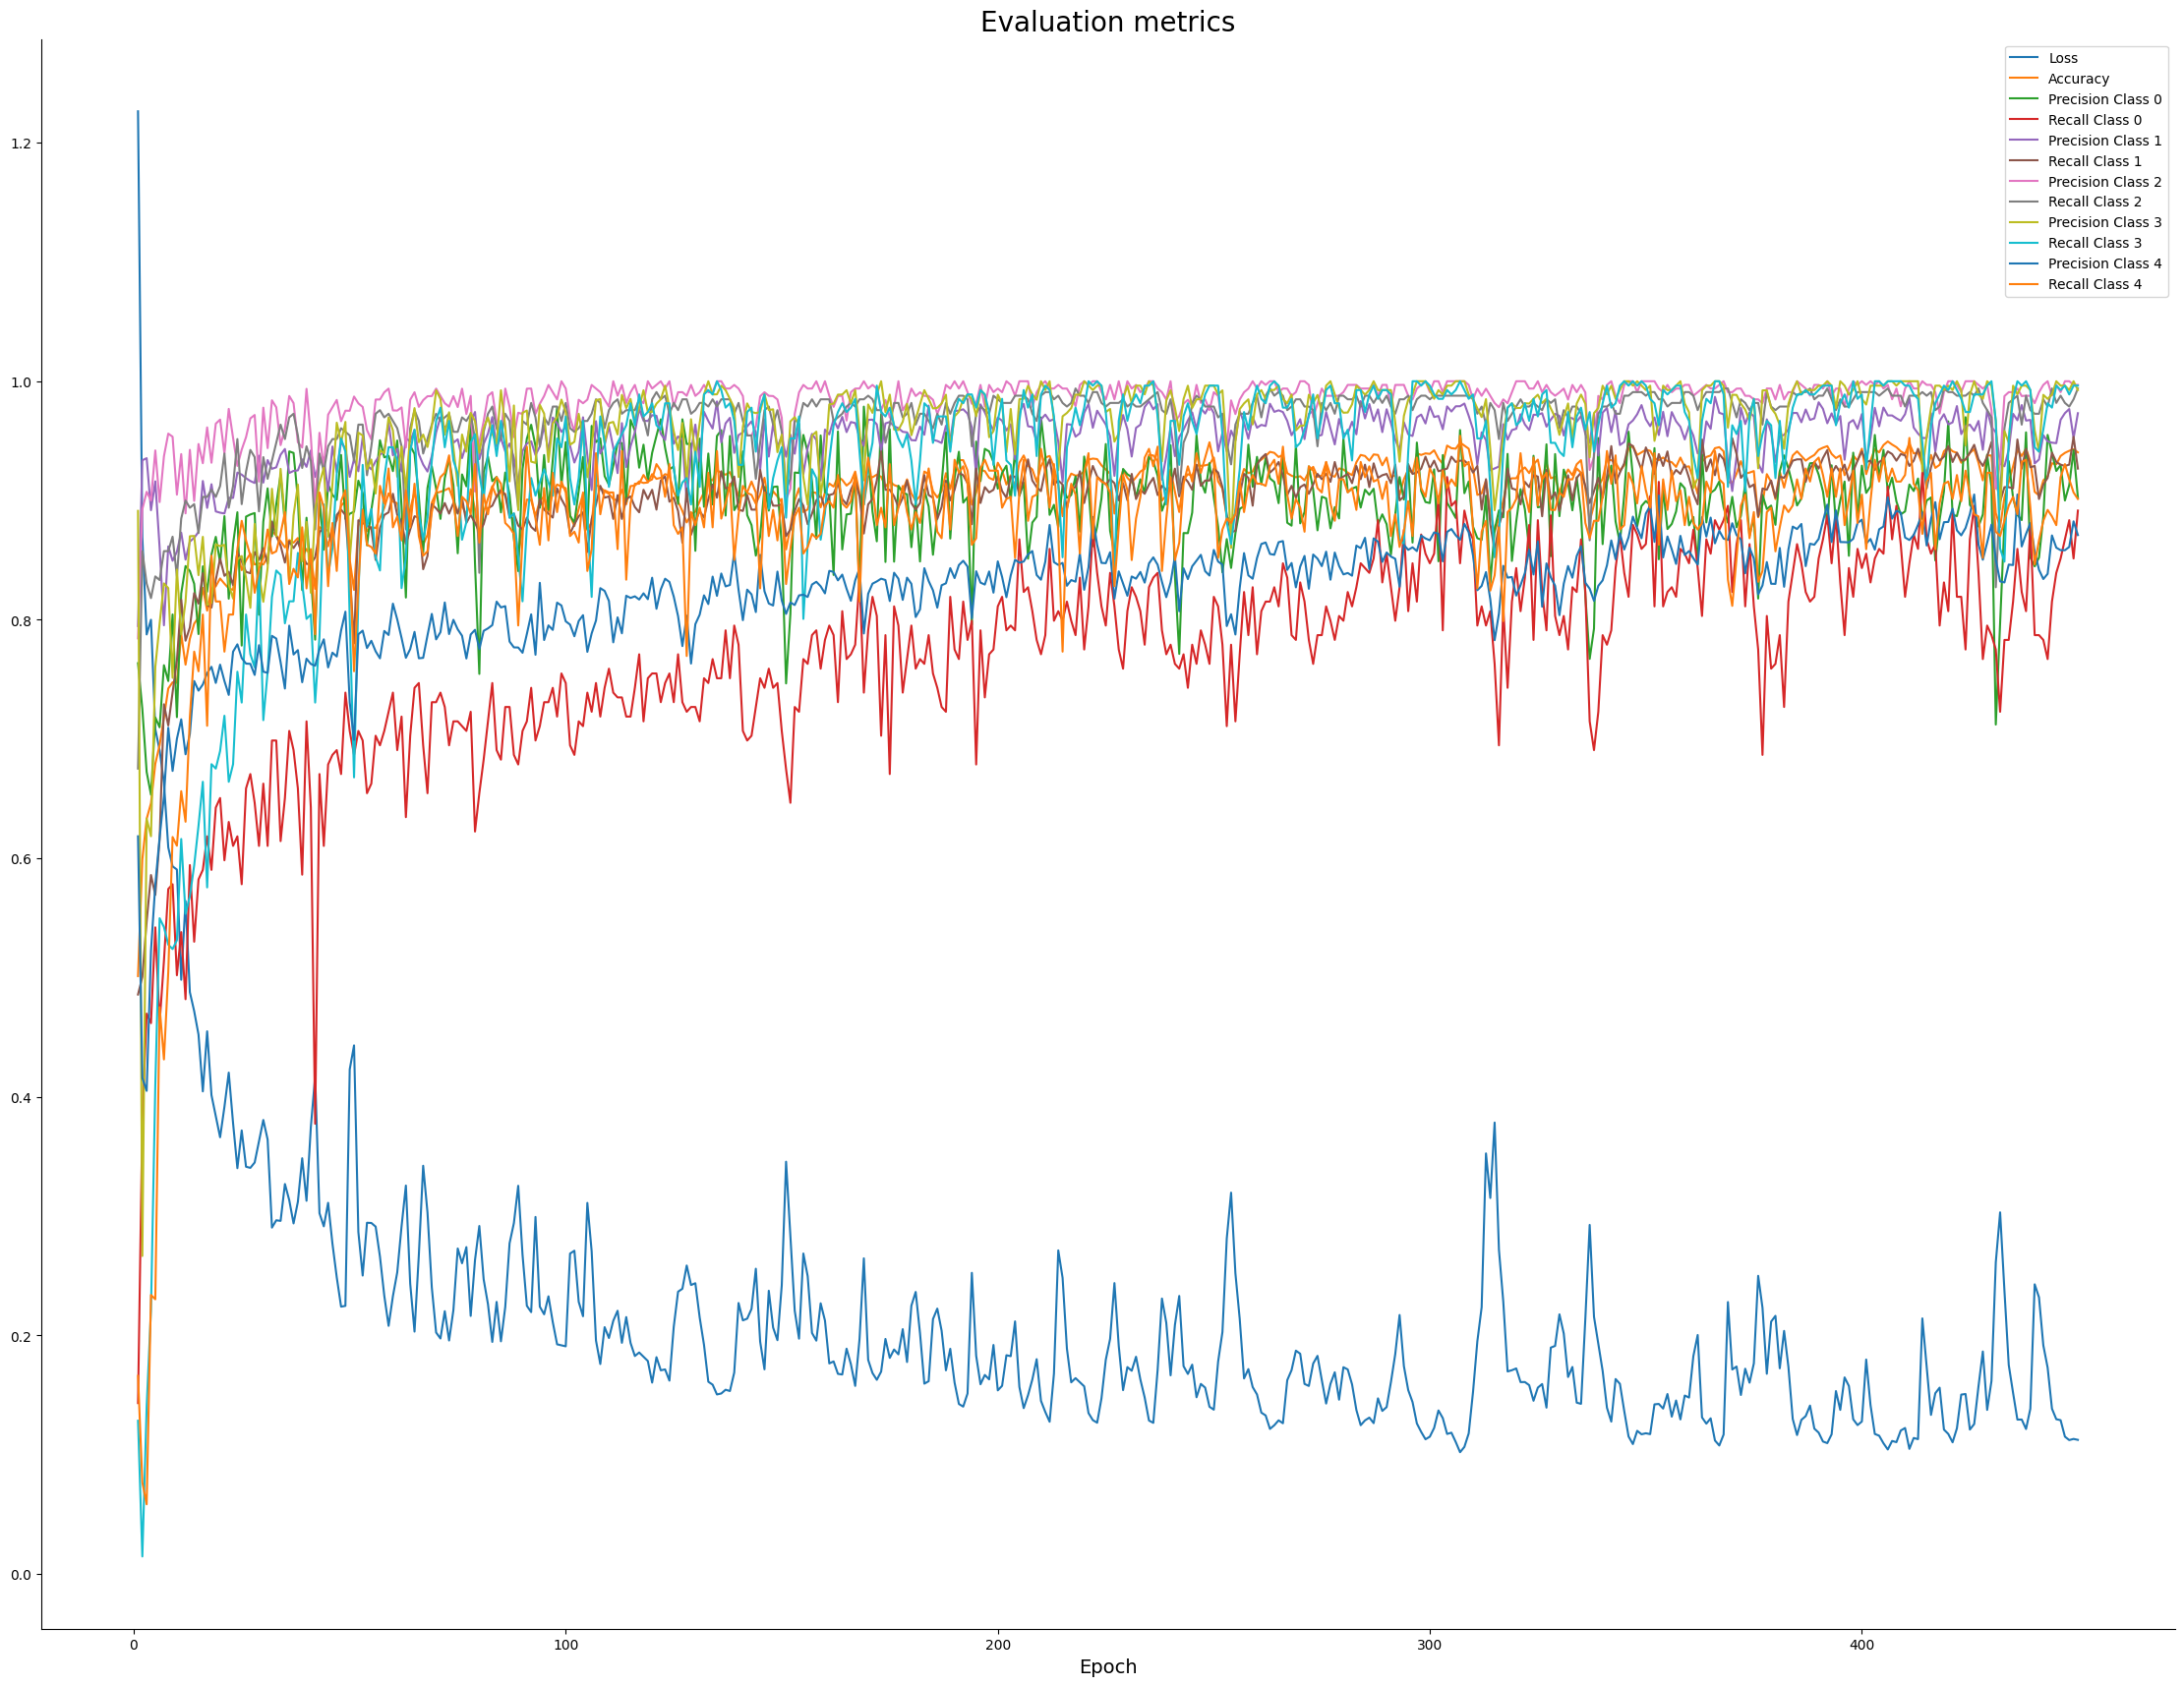

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
import numpy as np

rcParams['figure.figsize'] = (28, 21)
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False

# Correcting the range of epochs to match the actual number of epochs trained
epochs_trained = len(history.history['loss']) 

# Plot Loss and Accuracy
plt.plot(
    np.arange(1, epochs_trained + 1),
    history.history['loss'], label='Loss'
)
plt.plot(
    np.arange(1, epochs_trained + 1),
    history.history['accuracy'], label='Accuracy'
)

# Plot Precision and Recall for each class
num_classes = 5  # Update this with the actual number of classes you have
for i in range(num_classes):
    precision_label = f'precision_class_{i}'
    recall_label = f'recall_class_{i}'
    
    # Check if precision and recall for each class are in history to avoid KeyError
    if precision_label in history.history:
        plt.plot(
            np.arange(1, epochs_trained + 1),
            history.history[precision_label], label=f'Precision Class {i}'
        )
    if recall_label in history.history:
        plt.plot(
            np.arange(1, epochs_trained + 1),
            history.history[recall_label], label=f'Recall Class {i}'
        )

plt.title('Evaluation metrics', size=20)
plt.xlabel('Epoch', size=14)
plt.legend()
plt.show()


In [ ]:
# Evaluate the model on the test data
test_loss, test_accuracy, *test_metrics = best_model.evaluate(X_test, y_test,verbose=0)
y_pred = best_model.predict(X_test,verbose=0)
print(test_metrics)
# Assuming the order of metrics is consistent with how we added them:
# test_metrics[0] -> precision_class_0, test_metrics[1] -> recall_class_0, etc.
metrics_per_class = {
    'Loss': test_loss,
    'Accuracy': test_accuracy,
}

num_classes = 5  # Update this with the actual number of classes you have
class_names = label_encoder.inverse_transform(np.unique(y_train_integer))

def compute_confusion_matrix(true, pred):
    classes = np.unique(true)
    conf_mat = [[0] * len(classes) for i in range(len(classes))]
    for i in range(len(true)):
        conf_mat[pred[i]][true[i]]+=1
    print("       Actual")
    print("      _",end="")
    for item in classes:
        print("____",end="")
    print()
    print("pred  |", end=" "),
    for item in classes:
        print("{:^3}".format(item), end=" ")
    print()
    for item in classes:
        print("{:^6}|".format(item), end=" ")
        for item2 in classes:
            print("{:^3}".format(conf_mat[item][item2]), end="|")
        print()
def compute_metrics_per_class(true, pred, test_metrics):
    classes = np.unique(true)
    conf_mat = np.zeros((len(classes), len(classes)), dtype=int)
    for i in range(len(true)):
        conf_mat[pred[i], true[i]] += 1

    num_classes = len(classes)
    max_class_name_length = max(len(name) for name in class_names)
    
    total_precision = 0
    total_recall = 0
    total_accuracy = 0

    for i in range(num_classes):
        precision = float(test_metrics[2 * i])  # Even indices for precision
        recall = float(test_metrics[2 * i + 1])  # Odd indices for recall
        accuracy = float(conf_mat[i, i]) / np.sum(conf_mat[:, i])  # Calculate accuracy for class i
        
        total_precision += precision
        total_recall += recall
        total_accuracy += accuracy

        print(f"{class_names[i]:<{max_class_name_length}} | Precision: {precision:.3f} | Recall: {recall:.3f} | Accuracy: {accuracy:.3f}")

    # Calculate and print the averages
    avg_precision = total_precision / num_classes
    avg_recall = total_recall / num_classes
    avg_accuracy = total_accuracy / num_classes
    print(f"\nAvg Precision: {avg_precision:.3f} | Avg Recall: {avg_recall:.3f} | Avg Accuracy: {avg_accuracy:.3f}")

y_pred_labels = np.argmax(y_pred, axis=1)
y_test_nums = np.argmax(y_test, axis=1)
print_dataset_split(y_train_integer,y_test_integer)
print()
print("=================================================================")

compute_confusion_matrix(y_test_nums.tolist(),y_pred_labels.tolist())
print()
print("=================================================================")
compute_metrics_per_class(y_test_nums.tolist(),y_pred_labels.tolist(),test_metrics)
print("HYPERPARAMS: LR:",best_params['learning_rate']," EPOCH:",best_params['epochs']," BATCH:",best_params['batch_size'])
print("=================================================================")


[0.800000011920929, 0.7123287916183472, 0.9045801758766174, 0.8943396210670471, 1.0, 0.969072163105011, 1.0, 0.8999999761581421, 0.7752808928489685, 0.8518518805503845]
Class Name  Train  Test
    Barley    249    73
      Corn    901   265
      Oats    330    97
   Sorghum    271    80
     Wheat    547   162

       Actual
      _____________________
pred  |  0   1   2   3   4  
  0   | 52 | 3 | 3 | 2 | 6 |
  1   |  6 |237| 0 | 2 |18 |
  2   |  0 | 0 |94 | 0 | 0 |
  3   |  0 | 0 | 0 |73 | 0 |
  4   | 15 |25 | 0 | 3 |138|

Barley  | Precision: 0.800 | Recall: 0.712 | Accuracy: 0.712
Corn    | Precision: 0.905 | Recall: 0.894 | Accuracy: 0.894
Oats    | Precision: 1.000 | Recall: 0.969 | Accuracy: 0.969
Sorghum | Precision: 1.000 | Recall: 0.900 | Accuracy: 0.912
Wheat   | Precision: 0.775 | Recall: 0.852 | Accuracy: 0.852

Avg Precision: 0.896 | Avg Recall: 0.866 | Avg Accuracy: 0.868
HYPERPARAMS: LR: 0.013578517831513363  EPOCH: 450.0  BATCH: 128
